## OCR recognition: LeNet on MNIST handwritten digit classification dataset
- Convolutional Neural Networks(CNN) are designed to recognize visual patterns directly from pixel images with minimal preprocessing.   
- LeNet is a CNN designed for handwritten and machine-printed character recognition. 
- LeNet consists of a convolutional layer followed by a pooling layer, another convolution layer followed by a pooling layer, and then two fully connected layers similar to the conventional multilayer perceptrons. 

### 1. Setup
- Import dependencies

In [1]:
from pylab import *
import sys,os 
#setting for inline plotting
%matplotlib inline

#set caffe_root and import caffe
caffe_root='/opt/caffe'
sys.path.insert(0,caffe_root+'python')
import caffe

- Download and prepare MNIST dataset 

In [2]:
#change directory to caffe_root
os.chdir(caffe_root)

#download data
!data/mnist/get_mnist.sh
#prepare data
!examples/mnist/create_mnist.sh

#change directory to caffe_root/examples 
os.chdir('examples')

### 2. Creating the Neural Network
- We will need two external files:  
  **net prototxt**: defines the network architecture and paths to the train/test data  
  **solver prototxt**: defines the learning parameters

In [3]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):    
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

- The net will been written to disk in a more verbose but human-readable serialization format using Google's protobuf library:

  - **Data Layer**: name: data, type: Data, input: reads data from the given lmdb source with a batch size of 64. Incoming pixel vlaues are scaled to be in the range of [0,1). Data layer produces two output blobs-  data and labels.  
  - **Convolution Layer**: name: conv1, type: Convolution, takes the data blob as input. It produces outputs on       20 channels, with the convolutional kernel size 5 and carried out with stride 1. Fillers are used for           random initialization of weight(e.g. xavier algorithm) and bias values.    
  - **Pooling layer**: name: pool1, type:Pooling, takes conv1 blob as input. Performs max pooling with a pool         kernel size 2 and a stride of 2.    
  - **Fully connected layer**: name:fc1, type: InnerProduct, takes pool2 blob as input and produces output on 500     channels.    
  - **ReLu**: ReLU (Rectified Linear) is an element-wise operation, hence in-place operations can be done to save     memory. Giving the     same names to the input and output layers specifies that the operation must be           performed in-place.      
  - **Loss Layer**: name: loss, type: SoftmaxWithLoss.It takes two blobs as input- prediction and loss, to           compute the loss function. The value of the loss function is reported when backpropagation starts.


In [4]:
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156885937
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

In [5]:
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


### 3. Loading and Checking the Solver  
- Load the solver (many inbuilt solvers like SGD, Adagrad,  Nesterov's accelerated gradient are available)

In [6]:
#load the SGD solver 
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

- check the dimensions of the intermediate features (blobs) and parameters. 

In [7]:
# each output is (batch size, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [8]:
# print the weight sizes
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

 - Run a forward pass on the train and test nets to check that they contain data:
 - Ensure that both training and testing nets can load data and have correct labels. 

In [9]:
solver.net.forward() #training net 
solver.test_nets[0].forward()  # there can be more than one test nets 

{'loss': array(2.2438278198242188, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


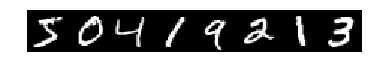

In [10]:
#print first 8 training images 
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


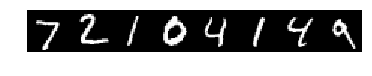

In [11]:
#print first 8 test images
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

### 4. Stepping through the Solver

In [12]:
solver.step(1)

- Check if gradients are propagating through the network. Print out the updates for any layer:

(-0.5, 24.5, 19.5, -0.5)

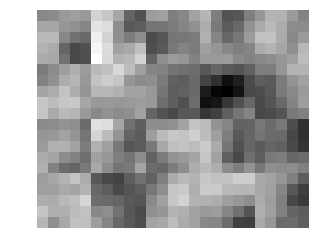

In [13]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

### 5. Training and Testing

In [24]:
%%time
niter = 200
test_interval = 25
# track training loss and accuracy
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))


# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    #(start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    # store the training loss
    train_loss[it] = solver.net.blobs['loss'].data    
        
    # run a full test at every test_interval     
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 1min 28s, sys: 36 ms, total: 1min 28s
Wall time: 1min 27s


- Plot training loss and Accuracy

Text(0.5,1,u'Test Accuracy: 0.98')

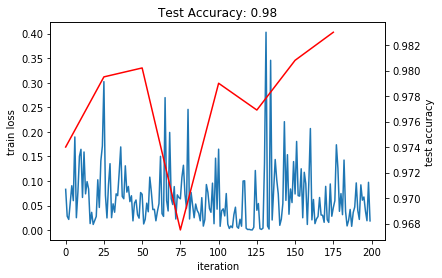

In [25]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

### 6. View Test Results
- plot the confidence of our net: 

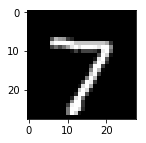

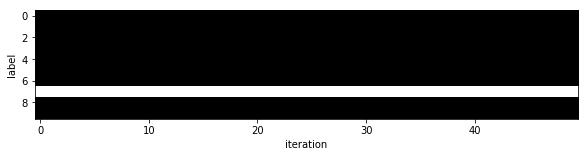

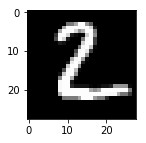

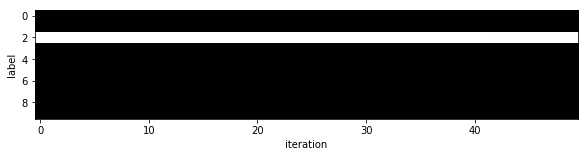

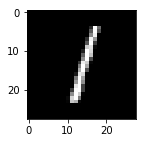

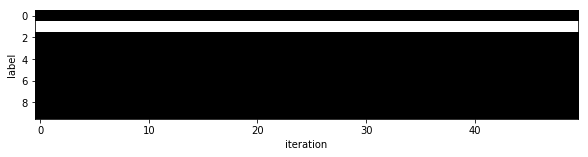

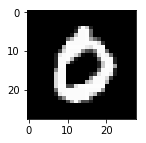

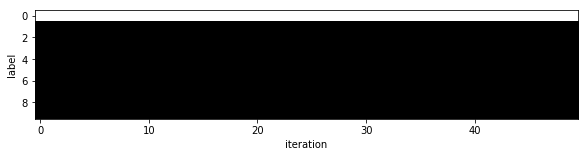

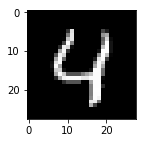

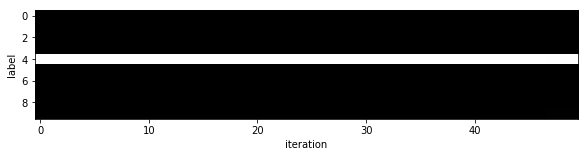

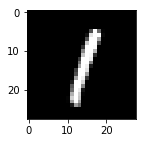

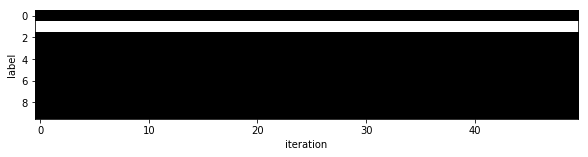

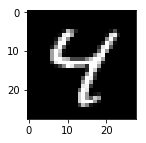

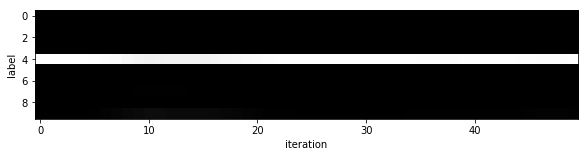

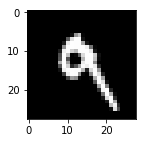

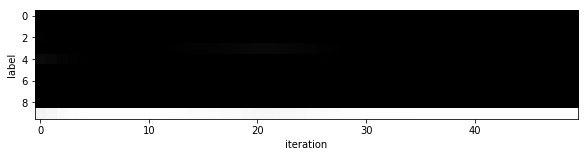

In [26]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')